<a href="https://colab.research.google.com/github/varunpenumudi/notes/blob/master/Pytorch_codemy/Simple_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# To import MNIST from datasets
from torchvision import datasets, transforms
from torchvision.utils import make_grid

# numpy and pandas for working with data
import numpy as np
import pandas as pd

# For Plotting Confusion Matrix of Model
from sklearn.metrics import confusion_matrix

# plot some graphs for data
import matplotlib.pyplot as plt
%matplotlib inline

# Get Train and Test Data

In [2]:
# Transform to Convert MNIST Images to (4D) Tensor  (# of images, Height, Width, Color Channel)
transform = transforms.ToTensor()

In [3]:
# Get Train Data
train_data = datasets.MNIST(root="/cnn_data", train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 50.8MB/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.86MB/s]

Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 7.39MB/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.83MB/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [4]:
# Test Data
test_data = datasets.MNIST(root="/cnn_data", train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# DataLoaders for loading train and test data in batches
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)    # no need to shuffle the test data

# How the Layers Works in CNN

In [8]:
# How the Convolutional Layer Works?

conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)   # 1 Images -> 6 Images
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)  # 6 Images -> 16 Images

In [9]:
# Grab 1 MNIST record/image
for i, (X_train, y_train) in enumerate(train_data):
    break

In [10]:
X_train.shape # a image of size 28 x 28

torch.Size([1, 28, 28])

In [11]:
x = X_train.view(1,1,28, 28)

In [12]:
# Perform first Convolution
x = F.relu(conv1(x))
x.shape

torch.Size([1, 6, 26, 26])

In [13]:
# Perform first Pooling
x = F.max_pool2d(x, 2, 2) # images, kernel, stride
x.shape

torch.Size([1, 6, 13, 13])

In [14]:
# Perform Second Convolution
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [15]:
# Second Pooling
x = F.max_pool2d(x, 2, 2)
x.shape

torch.Size([1, 16, 5, 5])

# First CNN Model

In [16]:
# Model Class
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)

        # Fully connected Layers
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):

        # Convolutional Layers
        X = F.relu(self.conv1(X)) # 1 Images (28*28)   -> 6 Images (26*26)
        X = F.max_pool2d(X, 2, 2) # 6 Images (26*26)  -> 6 Images(13*13)
        X = F.relu(self.conv2(X)) # 6 Images (13*13)  -> 16 Images(11*11)
        X = F.max_pool2d(X, 2, 2) # 16 Images (11*11) -> 16 Images(5*5)

        # Flatten Image Data
        X = X.view(-1, 16*5*5)

        # Fully Connected Layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)

In [17]:
torch.manual_seed(101)
model = SimpleCNN()
model

SimpleCNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
# Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Learn Slowly

# Train and Test CNN Model

In [19]:
import time
start_time = time.time()

# Create Variables to Track Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []


# For Loop for Epochs
for i in range(epochs):
    train_corr = 0
    test_corr = 0

    # Train
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()

        train_corr += batch_corr

        # Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print out some results
        if b%600 == 0:
            print(f"Epoch: {i}  Batch: {b}  Loss: {loss.item()}")

    train_losses.append(loss)
    train_correct.append(train_corr)

    # Test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            pred = torch.max(y_val.data, 1)[1]

            batch_corr = (pred == y_test).sum()
            test_corr += batch_corr

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)



cur_time = time.time()
total_time = cur_time-start_time
print(f"Training Took: {total_time/60} minutes!")

Epoch: 0  Batch: 600  Loss: 0.27714279294013977
Epoch: 0  Batch: 1200  Loss: 0.05869954079389572
Epoch: 0  Batch: 1800  Loss: 0.14001299440860748
Epoch: 0  Batch: 2400  Loss: 0.14789725840091705
Epoch: 0  Batch: 3000  Loss: 0.015575326979160309
Epoch: 0  Batch: 3600  Loss: 0.011459420435130596
Epoch: 0  Batch: 4200  Loss: 0.009168890304863453
Epoch: 0  Batch: 4800  Loss: 0.00417522294446826
Epoch: 0  Batch: 5400  Loss: 0.002396020805463195
Epoch: 0  Batch: 6000  Loss: 0.003313155844807625
Epoch: 1  Batch: 600  Loss: 0.02910645864903927
Epoch: 1  Batch: 1200  Loss: 0.09715400636196136
Epoch: 1  Batch: 1800  Loss: 0.0060613942332565784
Epoch: 1  Batch: 2400  Loss: 0.022610651329159737
Epoch: 1  Batch: 3000  Loss: 0.04838515818119049
Epoch: 1  Batch: 3600  Loss: 0.005749894306063652
Epoch: 1  Batch: 4200  Loss: 0.25272902846336365
Epoch: 1  Batch: 4800  Loss: 0.0002936680684797466
Epoch: 1  Batch: 5400  Loss: 0.24952879548072815
Epoch: 1  Batch: 6000  Loss: 0.012904241681098938
Epoch: 2  

# Graph CNN Results

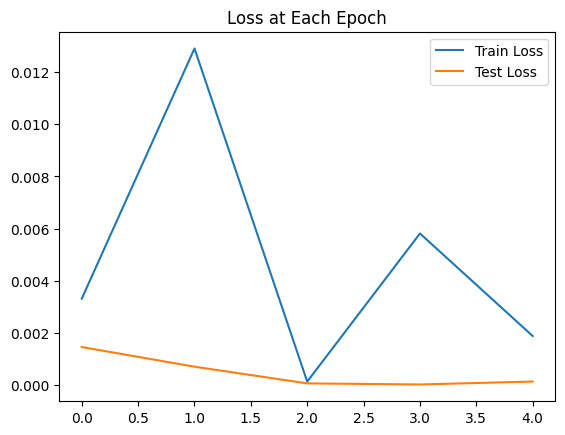

In [20]:
plt.plot([t.item() for t in train_losses], label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss at Each Epoch")
plt.legend()

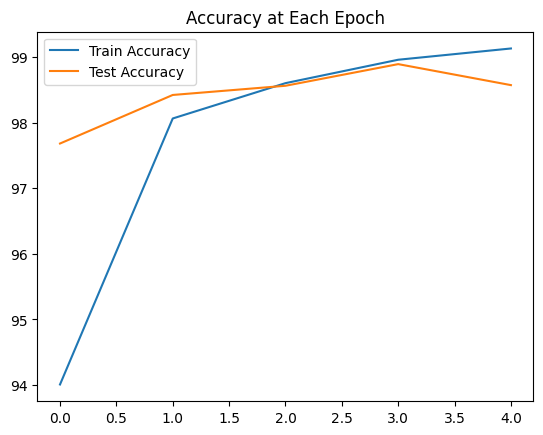

In [21]:
plt.plot([t/600 for t in train_correct], label="Train Accuracy")
plt.plot([t/100 for t in test_correct], label="Test Accuracy")
plt.title("Accuracy at Each Epoch")
plt.legend()

In [22]:
test_load_everything = DataLoader(test_data, 10000, False)

In [23]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        pred = torch.max(y_val.data, 1)[1]
        correct += (pred == y_test).sum()

In [31]:
correct.item()/len(test_data)

0.9857

# New Image Through Model

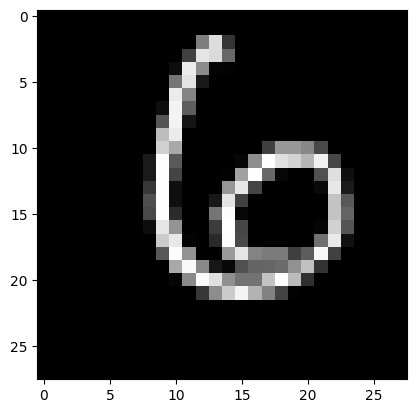

In [46]:
image = test_data[100][0]
plt.imshow(image.view(28, 28), cmap='gray')

In [49]:
with torch.no_grad():
    res = model(image.view(1,1,28,28))
res.argmax()

tensor(6)